In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

In [2]:
# Define the data folder and cities
data_dir = 'data/'  # Change if your folder is different
cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 'london', 'paris', 'rome', 'vienna']
df_list = []  # List to hold all DataFrames

# Loop through each city and day type
for city in cities:
    for day_type in ['weekdays', 'weekends']:
        file = f"{city}_{day_type}.csv"
        path = os.path.join(data_dir, file)
        if os.path.exists(path):
            df = pd.read_csv(path)
            df['city'] = city.capitalize()  # Add city column (e.g., 'Amsterdam')
            df['is_weekend'] = 1 if 'weekends' in day_type else 0  # Add weekend flag
            df_list.append(df)
        else:
            print(f"File not found: {file}")

# Combine all into one DataFrame
data = pd.concat(df_list, ignore_index=True)
print(data.shape)  # Shows rows and columns, e.g., (51707, 22)
data.head()  # Preview first 5 rows

(51707, 22)


,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,is_weekend
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,0
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,0
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,0
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,0
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,0


In [3]:
# Summary statistics
data.describe()

# Check missing values
print(data.isnull().sum())  # Shows count of NaNs per column

# Check data types
print(data.dtypes)

Unnamed: 0                    0
realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
is_weekend                    0
dtype: int64
Unnamed: 0                      int64
realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi            

In [5]:
# Drop rows with missing target (realSum)
data = data.dropna(subset=['realSum'])

# Fill missing values in ratings (use median to avoid bias)
data['cleanliness_rating'] = data['cleanliness_rating'].fillna(data['cleanliness_rating'].median())
data['guest_satisfaction_overall'] = data['guest_satisfaction_overall'].fillna(data['guest_satisfaction_overall'].median())

# Convert booleans to int (for modeling)
data['host_is_superhost'] = data['host_is_superhost'].astype(int)
data['room_shared'] = data['room_shared'].astype(int)
data['room_private'] = data['room_private'].astype(int)

# Handle outliers: Cap prices at 99th percentile (remove extreme highs)
price_cap = data['realSum'].quantile(0.99)
data = data[data['realSum'] <= price_cap]

# Drop unnecessary columns (optional)
# data = data.drop(['lng', 'lat'], axis=1)

print(data.shape)  # Check new shape
data.head()

(50677, 22)


,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,is_weekend
0,0,194.033698,Private room,0,1,2.0,0,1,0,10.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,0
1,1,344.245776,Private room,0,1,4.0,0,0,0,8.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,0
2,2,264.101422,Private room,0,1,2.0,0,0,1,9.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,0
3,3,433.529398,Private room,0,1,4.0,0,0,1,9.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,0
4,4,485.552926,Private room,0,1,2.0,1,0,0,10.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,0


In [6]:
data.to_csv('cleaned_airbnb_data.csv', index=False)

is_weekend           0           1
city                              
Amsterdam   438.554667  479.381687
Athens      148.595387  147.239366
Barcelona   267.194232  264.984548
Berlin      228.013604  234.923520
Budapest    164.187030  181.071554
Lisbon      235.504267  239.207322
London      306.524247  311.178464
Paris       355.074149  353.431889
Rome        198.198035  205.384585
Vienna      225.334991  235.279224


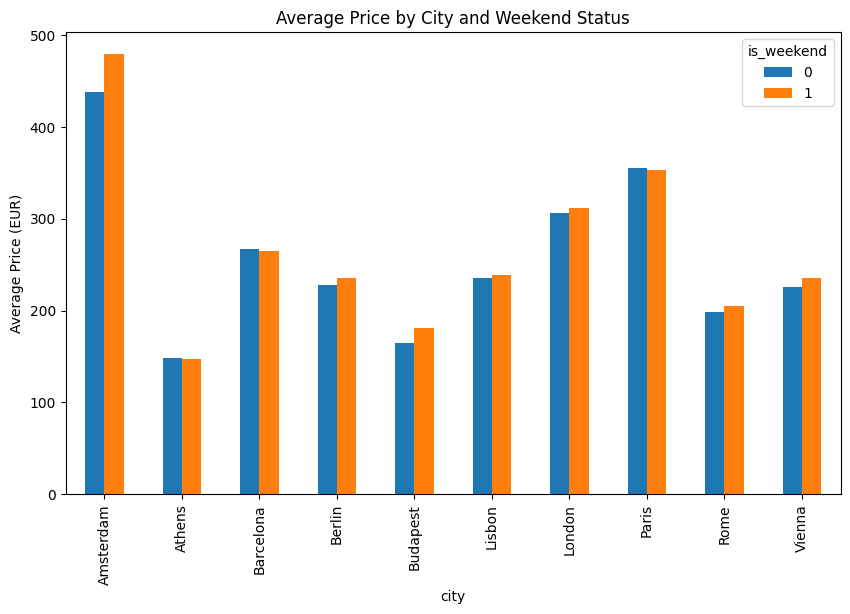

In [7]:
# Average price by city and weekend
avg_by_city_weekend = data.groupby(['city', 'is_weekend'])['realSum'].mean().unstack()
print(avg_by_city_weekend)

# Visualize
avg_by_city_weekend.plot(kind='bar', figsize=(10,6))
plt.title('Average Price by City and Weekend Status')
plt.ylabel('Average Price (EUR)')
plt.show()

quality_tier            Low      Medium        High
room_type                                          
Entire home/apt  323.565249  299.675816  280.893372
Private room     185.457944  182.209627  204.512032
Shared room      136.255169  135.201289  156.976585


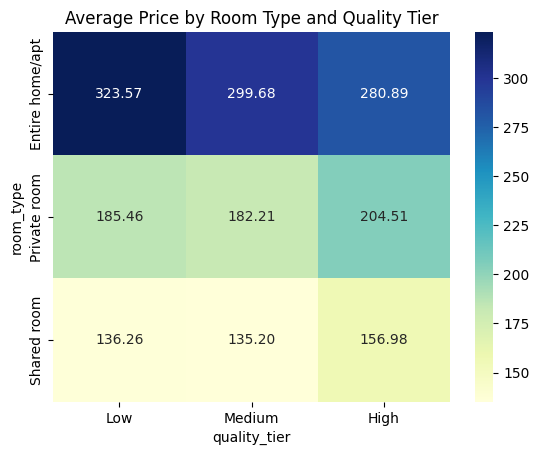

In [9]:
# Create quality tiers based on reviews
data['quality_tier'] = pd.cut(data['cleanliness_rating'], bins=[0,7,9,10], labels=['Low', 'Medium', 'High'])

# Average price by room type and quality
avg_by_type_quality = data.groupby(['room_type', 'quality_tier'], observed=True)['realSum'].mean().unstack()
print(avg_by_type_quality)

# Visualize
sns.heatmap(avg_by_type_quality, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Average Price by Room Type and Quality Tier')
plt.show()


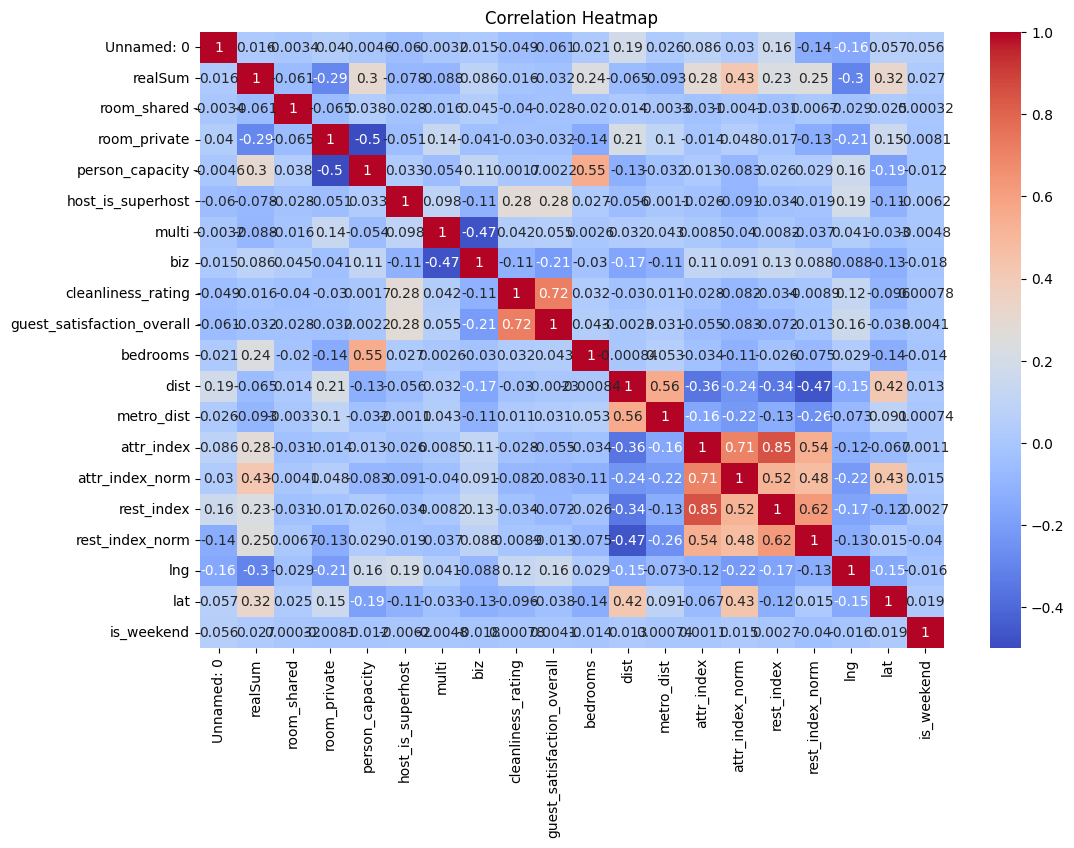

In [10]:
# Select numeric columns for correlation
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = data[numeric_cols].corr()

# Visualize top correlations with price
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [11]:
# Encode categorical variables (city, room_type)
categorical_cols = ['city', 'room_type']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = pd.DataFrame(encoder.fit_transform(data[categorical_cols]), columns=encoder.get_feature_names_out())
data_encoded = pd.concat([data.drop(categorical_cols, axis=1).reset_index(drop=True), encoded_cats], axis=1)

# Features and target
features = ['is_weekend', 'room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz',
            'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist',
            'attr_index_norm', 'rest_index_norm'] + list(encoded_cats.columns)
X = data_encoded[features]
y = data_encoded['realSum']

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} EUR")

# Coefficients for interpretability
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

R² Score: 0.59
MAE: 70.59 EUR
                            OLS Regression Results                            
Dep. Variable:                realSum   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2470.
Date:                Tue, 26 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:13:12   Log-Likelihood:            -2.4361e+05
No. Observations:               40541   AIC:                         4.873e+05
Df Residuals:                   40517   BIC:                         4.875e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [13]:
def recommend_price(input_dict):
    """
    Input: dict e.g., {'city': 'Paris', 'is_weekend': 1, 'room_type': 'Entire home/apt', 'person_capacity': 4, ...}
    Output: Predicted price in EUR
    """
    input_df = pd.DataFrame([input_dict])
    input_cats = encoder.transform(input_df[['city', 'room_type']])
    input_cats_df = pd.DataFrame(input_cats, columns=encoder.get_feature_names_out())
    input_features = input_df.drop(['city', 'room_type'], axis=1)
    input_X = pd.concat([input_features, input_cats_df], axis=1)[features]  # Align columns
    return model.predict(input_X)[0]

# Test example
example = {
    'city': 'Paris', 'is_weekend': 1, 'room_type': 'Entire home/apt', 'room_shared': 0, 'room_private': 0,
    'person_capacity': 4, 'host_is_superhost': 1, 'multi': 0, 'biz': 0, 'cleanliness_rating': 9.8,
    'guest_satisfaction_overall': 97, 'bedrooms': 2, 'dist': 1.5, 'metro_dist': 0.2,
    'attr_index_norm': 80, 'rest_index_norm': 75
}
print(f"Recommended Price: €{recommend_price(example):.2f}")

Recommended Price: €687.42


In [14]:
from sklearn.metrics import r2_score, mean_absolute_error

# Assuming X_test, y_test are from your train_test_split
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} EUR")

R² Score: 0.59
MAE: 70.59 EUR


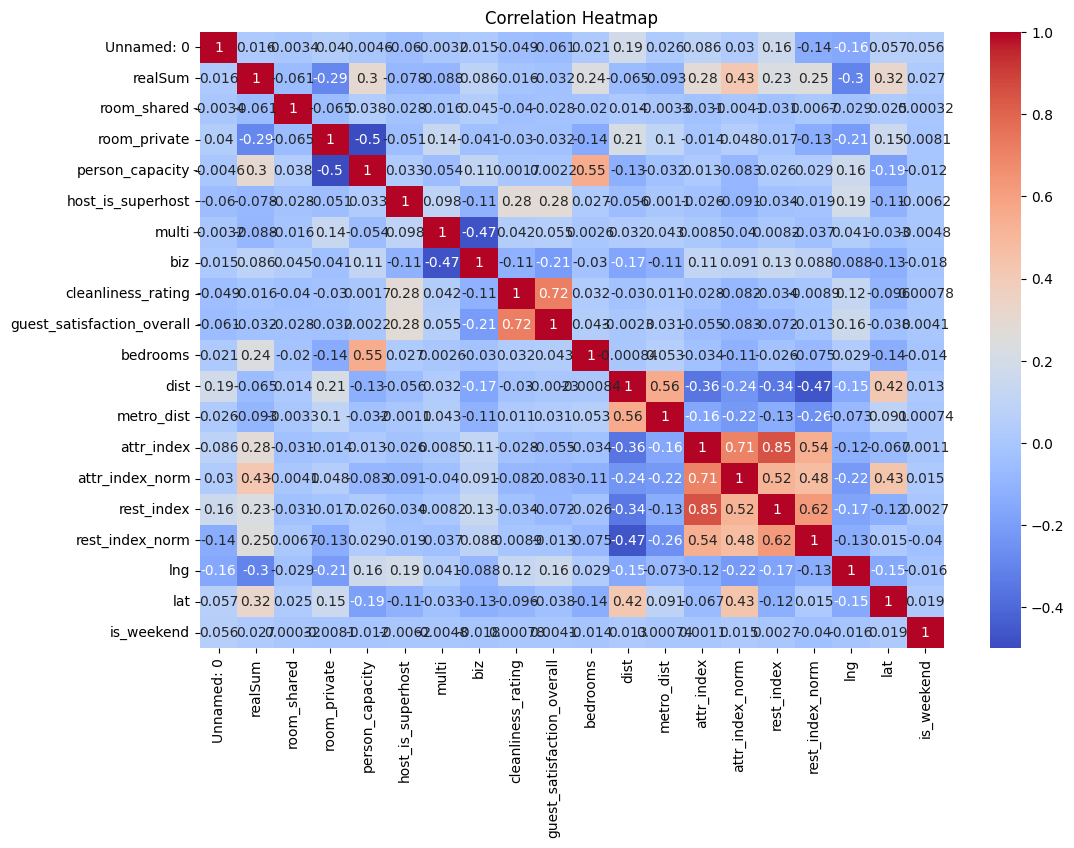

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [16]:
columns_to_keep = [col for col in data.columns if col not in ['attr_index', 'rest_index']]  # Drop original indices
data_cleaned = data[columns_to_keep]

# Re-run model with updated data if desired
# (Repeat encoding, train_test_split, and model fitting)

In [17]:
import pandas as pd
import numpy as np

In [18]:
# Load the cleaned data
data_cleaned = pd.read_csv('cleaned_airbnb_data.csv')
print(data_cleaned.shape)  # Check the number of rows and columns
data_cleaned.head()  # Preview the first 5 rows

(50677, 22)


,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,is_weekend
0,0,194.033698,Private room,0,1,2.0,0,1,0,10.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,0
1,1,344.245776,Private room,0,1,4.0,0,0,0,8.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,0
2,2,264.101422,Private room,0,1,2.0,0,0,1,9.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,0
3,3,433.529398,Private room,0,1,4.0,0,0,1,9.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,0
4,4,485.552926,Private room,0,1,2.0,1,0,0,10.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,0


In [19]:
print(data_cleaned.isnull().sum())  # Check for remaining missing values

Unnamed: 0                    0
realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
is_weekend                    0
dtype: int64


In [21]:
data_cleaned = pd.read_csv('cleaned_airbnb_data.csv')

In [22]:
data_dir = 'data/'
cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 'london', 'paris', 'rome', 'vienna']
df_list = []

for city in cities:
    for day_type in ['weekdays', 'weekends']:
        file = f"{city}_{day_type}.csv"
        path = os.path.join(data_dir, file)
        if os.path.exists(path):
            df = pd.read_csv(path)
            df['city'] = city.capitalize()
            df['is_weekend'] = 1 if 'weekends' in day_type else 0
            df_list.append(df)
        else:
            print(f"File not found: {file}")

data = pd.concat(df_list, ignore_index=True)

# Clean the data
data = data.dropna(subset=['realSum'])
data['cleanliness_rating'].fillna(data['cleanliness_rating'].median(), inplace=True)
data['guest_satisfaction_overall'].fillna(data['guest_satisfaction_overall'].median(), inplace=True)
data['host_is_superhost'] = data['host_is_superhost'].astype(int)
data['room_shared'] = data['room_shared'].astype(int)
data['room_private'] = data['room_private'].astype(int)
price_cap = data['realSum'].quantile(0.99)
data = data[data['realSum'] <= price_cap]

# Save again
data.to_csv('cleaned_airbnb_data.csv', index=False)
print("Cleaned data saved as cleaned_airbnb_data.csv")
data_cleaned = data  # Assign to data_cleaned for consistency
print(data_cleaned.shape)
data_cleaned.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11820\2049532992.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['cleanliness_rating'].fillna(data['cleanliness_rating'].median(), inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_11820\2049532992.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

Cleaned data saved as cleaned_airbnb_data.csv
(51189, 22)


,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,is_weekend
0,0,194.033698,Private room,0,1,2.0,0,1,0,10.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,0
1,1,344.245776,Private room,0,1,4.0,0,0,0,8.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,0
2,2,264.101422,Private room,0,1,2.0,0,0,1,9.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,0
3,3,433.529398,Private room,0,1,4.0,0,0,1,9.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,0
4,4,485.552926,Private room,0,1,2.0,1,0,0,10.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,0


In [1]:
import pandas as pd
data_cleaned = pd.read_csv('cleaned_airbnb_data.csv')
data_cleaned.columns = ['Listing ID', 'Price (EUR)', 'Room Type', 'Is Shared Room', 'Is Private Room', 'Max Guests', 'Is Superhost', 'Has Multiple Listings', 'Is Business Ready', 'Cleanliness Score', 'Guest Satisfaction (%)', 'Number of Bedrooms', 'Distance to Center (km)', 'Distance to Metro (km)', 'Attraction Index', 'Normalized Attraction Index', 'Restaurant Index', 'Normalized Restaurant Index', 'Longitude', 'Latitude', 'City', 'Is Weekend']
data_cleaned.to_csv('cleaned_airbnb_data_with_headers.csv', index=False)

In [2]:
import pandas as pd

# Load your cleaned dataset
cleaned_airbnb_dataset = pd.read_csv("cleaned_airbnb_dataset.csv")

# Check the first few rows
print(cleaned_airbnb_dataset.head())


   Listing ID  Price (EUR)     Room Type  Is Shared Room  Is Private Room  \
0           0   194.033698  Private room               0                1   
1           1   344.245776  Private room               0                1   
2           2   264.101422  Private room               0                1   
3           3   433.529398  Private room               0                1   
4           4   485.552926  Private room               0                1   

   Max Guests  Is Superhost  Has Multiple Listings  Is Business Ready  \
0         2.0             0                      1                  0   
1         4.0             0                      0                  0   
2         2.0             0                      0                  1   
3         4.0             0                      0                  1   
4         2.0             1                      0                  0   

   Cleanliness Score  ...  Distance to Center (km)  Distance to Metro (km)  \
0               10.0

In [5]:
print(cleaned_airbnb_dataset.columns)


Index(['Listing ID', 'Price (EUR)', 'Room Type', 'Is Shared Room',
       'Is Private Room', 'Max Guests', 'Is Superhost',
       'Has Multiple Listings', 'Is Business Ready', 'Cleanliness Score',
       'Guest Satisfaction (%)', 'Number of Bedrooms',
       'Distance to Center (km)', 'Distance to Metro (km)', 'Attraction Index',
       'Normalized Attraction Index', 'Restaurant Index',
       'Normalized Restaurant Index', 'Longitude', 'Latitude', 'City',
       'Is Weekend'],
      dtype='object')


In [7]:
print(cleaned_airbnb_dataset.columns.tolist())



['Listing ID', 'Price (EUR)', 'Room Type', 'Is Shared Room', 'Is Private Room', 'Max Guests', 'Is Superhost', 'Has Multiple Listings', 'Is Business Ready', 'Cleanliness Score', 'Guest Satisfaction (%)', 'Number of Bedrooms', 'Distance to Center (km)', 'Distance to Metro (km)', 'Attraction Index', 'Normalized Attraction Index', 'Restaurant Index', 'Normalized Restaurant Index', 'Longitude', 'Latitude', 'City', 'Is Weekend']


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

# Drop target + ID
X = cleaned_airbnb_dataset.drop(["Price (EUR)", "Listing ID"], axis=1)

# Encode categorical variables (Room Type, City, etc.)
X = pd.get_dummies(X, drop_first=True)

# Target
y = cleaned_airbnb_dataset["Price (EUR)"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Create predictions DataFrame (map back Listing ID)
predictions = pd.DataFrame({
    "Listing ID": cleaned_airbnb_dataset.loc[X_test.index, "Listing ID"],
    "Predicted Price": y_pred
})

# Save to CSV
predictions.to_csv("listing_predictions.csv", index=False)
print("✅ listing_predictions.csv saved successfully!")



✅ listing_predictions.csv saved successfully!


In [2]:
import pandas as pd

# Load the CSV file first
listing_predictions = pd.read_csv("listing_predictions.csv")

# Remove duplicates by averaging predicted price per Listing ID
listing_predictions = listing_predictions.groupby("Listing ID", as_index=False).agg({
    "Predicted Price": "mean"   # or "first" if you want the first occurrence
})

# Save back to CSV
listing_predictions.to_csv("listing_predictions.csv", index=False)

